In [88]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse
from qdrant_client import QdrantClient
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.tools import WikipediaQueryRun
from langchain_tavily import TavilySearch
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain.agents import create_agent


from dataclasses import dataclass
from pydantic import BaseModel, Field
from typing import List
from langchain_core.documents import Document

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from typing import List, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage
from pprint import pprint
load_dotenv()


True

In [89]:
class ProcessLoader:

    def __init__(self):
        self.client = QdrantClient(
                            url=os.getenv('QDRANT_API_URL'),
                            api_key=os.getenv('QDRANT_API_KEY')
                        )
        self.dense_embedding = HuggingFaceEmbeddings(model = 'sentence-transformers/all-MiniLM-L12-v2')
        self.sparse_embedding = FastEmbedSparse(model_name ='Qdrant/bm25')
        
        self.qdrantdb = QdrantVectorStore(
            client=self.client,
            collection_name= os.getenv('COLLECTIONNAME'),
            embedding=self.dense_embedding,
            sparse_embedding=self.sparse_embedding
        )
        self.wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results= 5, doc_content_chars_max= 2000))
        self.tavily_tool = TavilySearch(
            max_results=5,
            topic="general",
        )

    @property
    def getPBIRetriver(self):

        return self.qdrantdb.as_retriever(
            search_type = 'mmr',
                search_kwarg = {
                    "k":10
                }
        )
    
    @property
    def wikiTool(self):
        return self.wiki_tool
    
    @property
    def tavilyTool(self):
        return self.tavily_tool
    
    @property
    def getllm(self):
        return ChatGroq(model='openai/gpt-oss-120b')
    
    


In [90]:
obj = ProcessLoader()
pbiRetriver = obj.getPBIRetriver

In [91]:
def generateRetriverDocs() -> Tool:

    """ 
    Retrieves relevant documents from a vector store based on a query sent by LLM. 
    This node handles the critical step of fetching context based on question attribute of state.


    :returs : Object of SelfReflection type where retrivedDocs will be populated by retriver (pbiRetriver)  
    """
    print('---- In generateRetriverDocs-------')
    def toolFun(query: str) -> str:
        results = pbiRetriver.invoke(query)
        return '\n\n'.join([doc.page_content for doc in results])
    
    return Tool(
        llm = obj.getllm,
        name= "getPowerBIDocs",
        description= "Power BI Docs",
        func= toolFun

    )
    





In [92]:
tavilyTool = obj.tavilyTool
wikiTool = obj.wikiTool
pbiTool = generateRetriverDocs()

---- In generateRetriverDocs-------


In [93]:
tools = [pbiTool, tavilyTool]

In [94]:
def getPrompt(promptInstruction : str) -> str:

    return f""" 
                ### 📝 GENERIC RESEARCH MANDATE ###

                    **PRIMARY TOPIC:** Based on User Query Topic should be taken

                    **RESEARCH OBJECTIVE:**
                    You are an expert, objective research analyst. Your task is to produce a comprehensive, multi-faceted report on the **PRIMARY TOPIC** that achieves a deep understanding of its current state, challenges, and future trajectory.

                    ---

                    ### 🔍 RESEARCH SCOPE & CONSTRAINTS ###
                    * **Timeframe:** Focus primarily on developments and data from the last **5 years** (e.g., 2020–present), unless historical context is strictly necessary to understand the current state.
                    * **Depth:** Research must move beyond Wikipedia-level summaries and include synthesis, analysis, and critical evaluation of information.
                    * **Exclusions:** Avoid pure dictionary definitions or tangential subjects. Focus exclusively on the topic's direct implications.

                    ---

                    ### 🔑 MANDATORY REPORT SECTIONS ###

                    The final output MUST be organized into the following four distinct sections.

                    **SECTION 1: Overview & Current State**
                    * **Goal:** Define the topic and establish its importance.
                    * **Content:** Provide a concise, professional definition. Detail the topic's current scale, major players, or widely accepted status quo.

                    **SECTION 2: Key Challenges & Controversies**
                    * **Goal:** Identify and analyze critical obstacles.
                    * **Content:** Identify and analyze the **three most significant challenges** or **major points of controversy** surrounding the topic. For each challenge, explain the nature of the problem and its primary contributing factors.

                    **SECTION 3: Emerging Trends & Future Trajectory**
                    * **Goal:** Forecast and highlight new developments.
                    * **Content:** Identify and analyze **two major emerging trends** or **potential future applications/solutions** that are likely to shape the topic over the next 5–10 years.

                    **SECTION 4: Conclusion & Strategic Implications**
                    * **Goal:** Summarize findings and provide actionable takeaways.
                    * **Content:** Summarize the main analytical findings. Answer this critical question: **"What is the single most important strategic implication for an organization or individual engaging with this topic?"**

                    ---

                    ### ✨ OUTPUT FORMATTING RULES ###
                    1.  **Tone:** Maintain an **analytical, objective, and professional** tone throughout.
                    2.  **Citations (Fictional):** For each of the three mandatory challenges and two emerging trends, invent and list a realistic-sounding **source type** (e.g., "[Source: 2024 Market Analysis Report]", "[Source: Nature Communications Paper, 2023]"). This simulates a research process and improves analytical depth.
                    3.  **Formatting:** Use markdown headings and bolding to clearly delineate the four sections and their sub-points.

                    NOTE: {promptInstruction}
                """

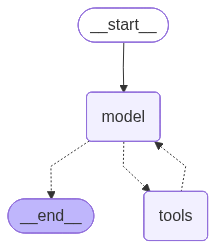

In [95]:
research_agent=create_agent(
                obj.getllm,
                tools=tools,
                system_prompt=getPrompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
                " You are working with a content writer colleague.")
)

research_agent


In [96]:
@dataclass
class MyastreamBot:
    messages: Annotated[List[AnyMessage], add_messages]

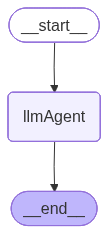

In [97]:
graph = StateGraph(MyastreamBot)

graph.add_node("llmAgent", research_agent)
graph.add_edge(START, "llmAgent")
graph.add_edge("llmAgent", END)

graph_builder = graph.compile()
graph_builder

In [101]:
result = graph_builder.invoke({"messages" : HumanMessage(content="Give Detailed Research on Power BI Services")})
print(result['messages'][-1])

content='## **SECTION 1 – Overview & Current State**\n\n**What is Power\u202fBI Service?**  \nPower\u202fBI Service (often simply called *Power\u202fBI*) is Microsoft’s cloud‑based SaaS platform for creating, publishing, and sharing interactive data visualisations, reports, and dashboards. It integrates tightly with the broader Microsoft Power\u202fPlatform (Power\u202fApps, Power\u202fAutomate, Power\u202fVirtual\u202fAgents) and Azure data services, providing a unified end‑to‑end analytics stack that spans data ingestion, modelling (via Power\u202fQuery and DAX), AI‑driven insights, and consumption on web, mobile, or embedded contexts.\n\n**Scale & Adoption (2020‑present)**  \n\n| Metric (2023‑24) | Figure / Insight |\n|------------------|------------------|\n| **Enterprise users** | >\u202f200\u202fmillion monthly active users globally (Microsoft FY‑2024 earnings release). |\n| **Revenue contribution** | Power\u202fBI accounted for ~\u202f$4.3\u202fbn of Microsoft’s “Intelligent Clo

In [ ]:
print(result['messages'][0])

content='Give Detailed Research on Power BI Services' additional_kwargs={} response_metadata={} id='3b01ea7a-1450-47ab-8ed7-3b1814299585'


In [103]:
print(result['messages'][1])

content='' additional_kwargs={'reasoning_content': "We need to produce a detailed research report on Power BI Services, following the mandatory sections. Must include citations (fictional) for each of three challenges and two emerging trends. Need to browse for up-to-date info (last 5 years). Use search tool to get sources. Let's search.", 'tool_calls': [{'id': 'fc_4a2afa1e-5b96-4661-93db-36d36b404875', 'function': {'arguments': '{"end_date":null,"exclude_domains":null,"include_domains":null,"include_favicon":false,"include_images":false,"query":"Power BI Service recent developments 2023 2024 adoption challenges","search_depth":"advanced","start_date":null,"time_range":"year","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 986, 'total_tokens': 1153, 'completion_time': 0.517396542, 'completion_tokens_details': {'reasoning_tokens': 60}, 'prompt_time': 0.088253806, 'prompt_tokens_details': {

In [104]:
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Give Detailed Research on Power BI Services
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_4a2afa1e-5b96-4661-93db-36d36b404875)
 Call ID: fc_4a2afa1e-5b96-4661-93db-36d36b404875
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: False
    include_images: False
    query: Power BI Service recent developments 2023 2024 adoption challenges
    search_depth: advanced
    start_date: None
    time_range: year
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Power BI Service recent developments 2023 2024 adoption challenges", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ttms.com/power-bi-implementation-challenges-pros-and-cons-you-should-know/", "title": "What are Power BI 